In [1]:
%matplotlib inline

import os
import platform, sys
print(f"Python: {platform.platform()}, version: {sys.version[0:6]}")

import numpy as np
import pandas as pd
import seaborn as sns

print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"seaborn: {sns.__version__}")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# plotting library
import matplotlib
import matplotlib.pyplot as plt 
print(f"matplotlib: {matplotlib.__version__}")

# ML-models library
import sklearn as sk
print(f"scikit-learn: {sk.__version__}")

# statistics library
import statsmodels
print(f"statsmodels: {statsmodels.__version__}")

import ast
import pickle

Python: Windows-11-10.0.26100-SP0, version: 3.13.9
numpy: 2.3.5
pandas: 2.3.3
seaborn: 0.13.2
matplotlib: 3.10.7
scikit-learn: 1.8.0
statsmodels: 0.14.6


## 1. Laad de data

In [2]:
LANGUAGES = ['aa', 'ab', 'af', 'ak', 'am', 'an', 'ar', 'as', 'av', 'ay', 'az', 'ba', 'be', 'bg', 'bi', 'bm', 'bn', 'bo', 'br', 'bs', 'ca', 'ce', 'ch', 'cn', 'co', 'cr', 'cs', 'cv', 'cy', 'da', 'de', 'dv', 'dz', 'ee', 'el', 'en', 'eo', 'es', 'et', 'eu', 'fa', 'ff', 'fi', 'fj', 'fo', 'fr', 'fy', 'ga', 'gd', 'gl', 'gn', 'gu', 'gv', 'ha', 'he', 'hi', 'ho', 'hr', 'ht', 'hu', 'hy', 'hz', 'ia', 'id', 'ie', 'ig', 'ik', 'io', 'is', 'it', 'iu', 'ja', 'jv', 'ka', 'kg', 'ki', 'kj', 'kk', 'kl', 'km', 'kn', 'ko', 'ks', 'ku', 'kv', 'kw', 'ky', 'la', 'lb', 'lg', 'li', 'ln', 'lo', 'lt', 'lv', 'mg', 'mh', 'mi', 'mk', 'ml', 'mn', 'mo', 'mr', 'ms', 'mt', 'my', 'nb', 'nd', 'ne', 'ng', 'nl', 'nn', 'no', 'nr', 'nv', 'ny', 'oc', 'oj', 'om', 'or', 'os', 'pa', 'pl', 'ps', 'pt', 'qu', 'rm', 'rn', 'ro', 'ru', 'rw', 'sa', 'sc', 'sd', 'se', 'sg', 'sh', 'si', 'sk', 'sl', 'sm', 'sn', 'so', 'sq', 'sr', 'ss', 'st', 'su', 'sv', 'sw', 'ta', 'te', 'tg', 'th', 'ti', 'tk', 'tl', 'tn', 'to', 'tr', 'ts', 'tt', 'tw', 'ty', 'ug', 'uk', 'ur', 'uz', 've', 'vi', 'wo', 'xh', 'xx', 'yi', 'yo', 'za', 'zh', 'zu']
GENRES = {'History', 'Action', 'Thriller', 'Science Fiction', 'Documentary', 'Western', 'Family', 'Drama', 'Fantasy', 'Comedy', 'Romance', 'TV Movie', 'Mystery', 'Adventure', 'Crime', 'Animation', 'Horror', 'Music', 'War'}


def load_csv_pd_data(path, filename, sep=';'):
    '''
    load_csv_pd_data() - construct a pandas DataFrame object 
           from data in a Excel csv-file `filename`,
           stored in a folder `path`.
    @returns: a pandas DataFrame
    '''
    csv_path = os.path.join(path, filename)
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"{csv_path} does not exist")

    return pd.read_csv(csv_path, sep=sep)


def load_movies():
    '''
    load_movies() - construct a pandas DataFrame object of the movies
            with all the normal numeric fields formatted to be
            accepted by matplotlib, with a weighted average field for the votes,
            and with unused fields already removed.  
    @returns: a pandas DataFrame
    '''

    # First check if the output csv already exists.
    # If it does, use that data instead ^^.
    output_path = os.path.join("output", "movies_cleaned.csv")
    if os.path.exists(output_path):
        return load_csv_pd_data("output", "movies_cleaned.csv", ",")

    movies = load_csv_pd_data("input", "data_movies_clean.csv")

    # Format fields.
    movies['vote_average'] = movies['vote_average'].str.replace(',', '.').astype(float)
    movies['budget'] = movies['budget'].str.replace(',', '.').astype(float)
    movies['revenue'] = movies['revenue'].str.replace(',', '.').astype(float)
    movies['release_date'] = pd.to_datetime(movies['release_date'], format='mixed')

    # Drop unused fields.
    movies = movies.drop(['title', 'adult', 'popularity'], axis=1)

    # Merge vote_average and vote_count -> weighted_vote.
    C = movies['vote_average'].mean()
    m = movies['vote_count'].quantile(0.80)

    v = movies['vote_count']
    R = movies['vote_average']

    movies['weighted_vote'] = np.where(
        (v > 0) & (R > 0), (v / (v + m)) * R + (m / (v + m)) * C, 0
    )

    # Convert non-number values through hashes or binary values.
    # Genres.
    genres_values = {genre: 1 << i for i, genre in enumerate(sorted(GENRES))}

    movies["genre_names"] = movies["genre_names"].apply(ast.literal_eval)
    movies["genre_numeric"] = movies["genre_names"].apply(lambda row: sum(genres_values[key] for key in row))

    # Countries.
    movies["origin_country"] = movies["origin_country"].apply(ast.literal_eval)
    movies["country_hash"] = movies["origin_country"].apply(lambda row: hash(tuple(sorted(row))))

    # Languages.
    movies["original_language_numeric"] = movies["original_language"].apply(lambda row: LANGUAGES.index(row))


    # Verwijder records waar runtime 0 of negatief is, of meer dan 300 minuten is.
    movies.drop(movies[(movies['runtime'] <= 1) | (movies['runtime'] >= 500)].index, inplace=True)

    # Verwijder records waar budget 1 of minder is.
    movies.drop(movies[(movies['budget'] <= 1)].index, inplace=True)

    # Je kan zien hoe revenue nog veel verschil heeft tussen de indie films, met outliers in de miljarden. 
    # De grafiek is hierom biased. Echter is dit onze target dus is het minder relevant voor ons onderzoek.

    # Dit gooit een heleboel records weg, van 750k naar 333k.
    movies.drop(movies[(movies['vote_count'] < 1)].index, inplace=True)

    return movies



movies = load_movies()
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333686 entries, 0 to 333685
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         333686 non-null  int64  
 1   original_language          333686 non-null  object 
 2   origin_country             333686 non-null  object 
 3   release_date               333686 non-null  object 
 4   genre_names                333686 non-null  object 
 5   production_company_names   333686 non-null  object 
 6   budget                     333686 non-null  float64
 7   revenue                    333686 non-null  float64
 8   runtime                    333686 non-null  int64  
 9   vote_average               333686 non-null  float64
 10  vote_count                 333686 non-null  int64  
 11  weighted_vote              333686 non-null  float64
 12  genre_numeric              333686 non-null  int64  
 13  country_hash               33

## 2. Gradient Boosting 

Gradient Boosting is een  manier om voorspellingen te doen door meerdere kleine decision threes samen te voegen. Elke boom probeert de fouten van de vorige te verbeteren, zodat het model steeds beter wordt. Het is een krachtige techniek die goed werkt voor ingewikkelde data.

## 3. Test/Train split

We splitsen de gegevens op in trainings- en testsets (80/20 split) en trainen een lineair regressiemodel.

Voor dit lineaire regressiemodel richten we ons op continue numerieke kenmerken die een geldige lineaire relatie hebben, met name:
- `budget`
- `runtime`
- `vote_average` / `vote_count` 

Deze kolommen komen vanuit de RandoForestRegressor, waar deze de hoogste feature_importance hadden.

In [3]:
features = ['budget', 'runtime', 'vote_average', 'vote_count']

X = movies[features]
y = movies['revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Length of train set: {len(X_train)}")
print(f"Length of test set: {len(X_test)}")


Length of train set: 266948
Length of test set: 66738


## 4. Train de regressor

Hier maken we en trainen we een GradientBoosting regressor model met de volgende hyperparameters:
- `n_estimators=100`: Het aantal bomen in het model. Hoe meer bomen, hoe complexer het model.
- `learning_rate=0.1`: De snelheid waarmee het model leert.
- `max_depth=3`: De maximale diepte van elke beslissingsboom. Dit voorkomt overfitting door de complexiteit van de bomen te beperken.
- `random_state=42`: Voor reproductie van de resultaten. Het zorgt ervoor dat de willekeurige processen in het model elke keer hetzelfde zijn.

We trainen het model op de trainingsdata, nog niet op de testdata


In [4]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft 

## 5. Test het model

Na het trainen van het model gebruiken we de testdata om voorspellingen te doen. Dit geeft ons de voorspelde waarden y_pred, die we vervolgens vergelijken met de werkelijke waarden om de prestaties van het model te evalueren.

In [5]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 3586564.0450847987
Mean Squared Error: 238743824165148.9
R-squared: 0.7768247672230141


## 6. Sla het model op

In deze stap slaan we het getrainde model op in een bestand met de naam `gradient_boosting_model.pkl`. Dit zorgt ervoor dat we het model later opnieuw kunnen gebruiken zonder het opnieuw te hoeven trainen, wat tijd en rekenkracht bespaart.

In [11]:
os.makedirs("output/models/", exist_ok=True)
with open('output/models/gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(model, f)

## 7. Visualisatie

Door de werkelijke waarden te visualiseren en de voorspelde waarden te vergelijken, kunnen we beter begrijpen waar het model goed presteert en waar het afwijkt.

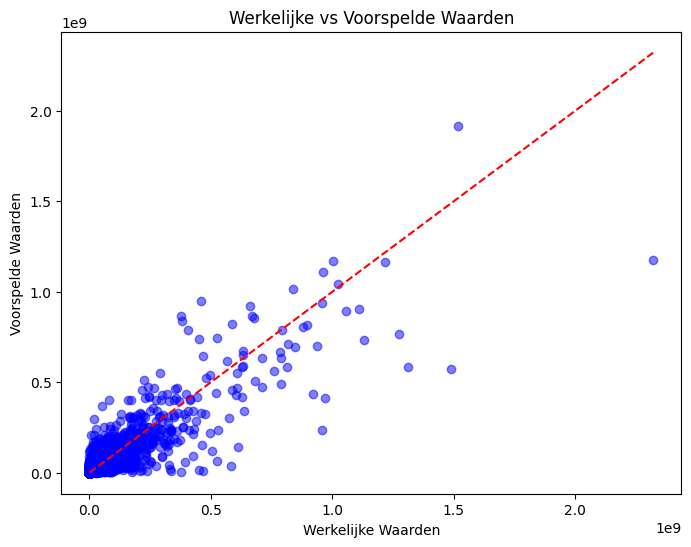

In [7]:
# Load the model we created in step 6.
with open('output/models/gradient_boosting_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

y_pred = loaded_model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.title('Werkelijke vs Voorspelde Waarden')
plt.xlabel('Werkelijke Waarden')
plt.ylabel('Voorspelde Waarden')
plt.show()

## 8. Conclusie

Hoewel het model een goede basis biedt voor het voorspellen van revenue, is de grote MAE en de hoge MSE een indicatie dat er heel veel outliers zijn, vooral bij films met extreem hoge inkomsten. De R-squared waarde is redelijk goed, maar het model heeft nog steeds onzekerheden die waarschijnlijk ontstaan binnen de data (zoals extreme outliers in de revenue). 

Al met al zou dit model in zijn huidige staat niet gebruikt kunnen worden voor nauwkeurige voorspellingen, maar het kan wel als een referentiepunt dienen. De resultaten zijn namelijk ruw wel correct.